# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from pandas_profiling import ProfileReport
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.metrics
from typing import List
from sklearn.model_selection import train_test_split
%matplotlib inline

# Preprocessing and Cleaning

In [ ]:
def handle_na_values(df, na_threshold):
    df = df.drop(columns=[col for col in df.columns if df[col].isna().sum() > na_threshold])
    na_free_data = df.dropna(how = "any")
    print("Number of NA in entire dataframe: ", sum(na_free_data.isna().sum().tolist()))
    return na_free_data

In [ ]:
def separate_dataset(df):
    target = df[["SalePrice"]]
    explanatory_variables = df.loc[:, df.columns != 'SalePrice']
    numeric_data = explanatory_variables.select_dtypes(include=[np.number])
    categorical_data = explanatory_variables.select_dtypes(exclude=[np.number])
    print("number of numerical columns:", numeric_data.shape[1])
    print("number of categorical columns:", categorical_data.shape[1])
    return numeric_data, categorical_data, target
    

In [ ]:
def process_num_cate_data(num_data, cate_data, target):
    # handle numerical data
    pearson_matrix = num_data.corr().abs()
    upper_matrix = pearson_matrix.where(np.triu(np.ones(pearson_matrix.shape), k=1).astype(bool))
    # Find features with correlation greater than 0.95
    to_drop_columns = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.8)]
    print("Columns to be dropped: ", to_drop_columns)
    # Drop features 
    corr_free_explain_var = num_data.drop(to_drop_columns, axis=1)

    # select best 20 variables
    col_needed = 20
    for col in cate_data.columns:
        encoder = LabelEncoder().fit(cate_data[col])
        cate_data[col] = encoder.transform(cate_data[col])
    
    skb = SelectKBest(chi2,k=col_needed)
    skb.fit(cate_data,target)
    nameidx = skb.get_support(indices=True)
    name = {}
    for i in range(col_needed):
        name[i]=cate_data.columns[nameidx[i]]
    transformed_cate_data=pd.DataFrame(skb.transform(cate_data)).rename(columns=name)
    
    return corr_free_explain_var, transformed_cate_data

## Read in the dataset

In [ ]:
train_data = pd.read_csv("train.csv")
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## process and clean data

In [ ]:
na_threshold = 100
na_free_data = handle_na_values(train_data, na_threshold)
print("na_free_data.shape: ", na_free_data.shape)
num_data, cate_data, target = separate_dataset(na_free_data)
print("numerical variable shape: ", num_data.shape)
print("categorical variable shape: ", cate_data.shape)
corr_free_explain_var, transformed_cate_data = process_num_cate_data(num_data, cate_data, target)
print("numerical variable shape after corrlation: ", corr_free_explain_var.shape)
print("categorical variable shape after transform: ", transformed_cate_data.shape)
print("Number of NA in entire dataframe: ", sum(corr_free_explain_var.isna().sum().tolist()))
print("Number of NA in entire dataframe: ", sum(transformed_cate_data.isna().sum().tolist()))

corr_free_explain_var = corr_free_explain_var.drop("Id", axis=1)
print("dropped id shape: ", corr_free_explain_var.shape)
normalized_df=(corr_free_explain_var-corr_free_explain_var.min())/(corr_free_explain_var.max()-corr_free_explain_var.min())
X = pd.concat([normalized_df.reset_index(), transformed_cate_data.reset_index()], axis=1, ignore_index=True)
y = target
print(X.shape)
print(y.shape)

Number of NA in entire dataframe:  0
na_free_data.shape:  (1338, 75)
number of numerical columns: 36
number of categorical columns: 38
numerical variable shape:  (1338, 36)
categorical variable shape:  (1338, 38)
Columns to be dropped:  ['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']
numerical variable shape after corrlation:  (1338, 32)
categorical variable shape after transform:  (1338, 20)
Number of NA in entire dataframe:  0
Number of NA in entire dataframe:  0
dropped id shape:  (1338, 31)
(1338, 53)
(1338, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(936, 53) (936, 1)
(402, 53) (402, 1)


# Building Neural Networks from scratch

In [ ]:
class NeuralNetwork():
    def __init__(self, num_features, layer_sizes, activations, loss, learning_rate):
        sizes = [num_features] + layer_sizes
        self.n_layers = len(layer_sizes)
        self.activations = activations
        self.loss = loss
        self.learning_rate = learning_rate
        self.W = []
        for i in range(self.n_layers):
            rand_weights = np.random.randn(sizes[i], sizes[i+1]) / np.sqrt(sizes[i])
            biases = np.zeros((1, sizes[i+1]))
            self.W.append(np.concatenate([biases, rand_weights], axis=0))
    def forward_pass(self, X):
        A_vals, Z_vals = [], []
        source = X
        for i in range(self.n_layers):
            # prepare information related to current layer
            curr_all_A = []
            curr_all_Z = []
            curr_weight_and_bias = self.W[i]
            curr_weight_and_bias = curr_weight_and_bias.T
            curr_weight = curr_weight_and_bias[:, 1:]
            curr_bias = curr_weight_and_bias[:, 0:1]
            curr_activation = self.activations[i]

            # loop sources. Source is data in first layer, but they are z values in other layers
            # refer report for details
            for d in range(source.shape[0]):
                single_source = source[d]
                single_source = np.expand_dims(single_source, axis=0).T
                a_without_bias = np.dot(curr_weight, single_source)
                a_for_single_source = a_without_bias + curr_bias
                z_for_single_source = curr_activation.value(a_for_single_source.T.squeeze(axis=0))
                curr_all_A.append(a_for_single_source.T.squeeze(axis=0))
                curr_all_Z.append(z_for_single_source)

            curr_all_A = np.array(curr_all_A)
            curr_all_Z = np.array(curr_all_Z)
            A_vals.append(curr_all_A)
            Z_vals.append(curr_all_Z)

            source = Z_vals[-1]

        return (A_vals, Z_vals)
    def backward_pass(self, A_vals, gradient):
        deltas = []
        last_delta = []
        # base case
        last_A = A_vals[-1]
        last_activation = self.activations[-1]
        g_prime_A = last_activation.derivative(last_A)
        for i in range(last_A.shape[0]):
            A_slice = g_prime_A[i,:]
            gradient = gradient[i]
            gradient = np.array(gradient)
            curr_res = A_slice * gradient
            last_delta.append(curr_res)
        deltas.append(np.array(last_delta))

        # recursive case (we do not use the first layer's W to calculate delta)
        for i in reversed(range(1,self.n_layers)):
            l_plus_one_delta = deltas[-1]
            l_plus_one_weight = self.W[i]
            l_plus_one_weight_T = l_plus_one_weight.T
            l_plus_one_weight_wo_bias = l_plus_one_weight_T[:,1:]
            delta_n_weight = np.dot(l_plus_one_delta, l_plus_one_weight_wo_bias)

            # summation * g'(a^l)
            curr_A = A_vals[i-1]
            curr_activation = self.activations[i-1]
            g_prime_A = curr_activation.derivative(curr_A)
            curr_delta = []
            for j in range(curr_A.shape[0]):
                delta_n_weight_slice = delta_n_weight[j,:]
                A_slice = g_prime_A[j,:]
                curr_res = delta_n_weight_slice * A_slice
                curr_delta.append(curr_res)

            deltas.append(np.array(curr_delta))
        deltas.reverse()
        return deltas

# Building an example model using Keras

In [ ]:
# define the keras model
model = Sequential()
model.add(Dense(200, input_shape=(53,), kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

In [ ]:
model.compile(loss='mean_squared_error', optimizer="adam", metrics =[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
# fit the keras model on the dataset
fit_history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test,y_test))

Epoch 1/200
30/30 [==============================] - 1s 7ms/step - loss: 43164160000.0000 - root_mean_squared_error: 207759.8594 - val_loss: 36197466112.0000 - val_root_mean_squared_error: 190256.3125
Epoch 2/200
30/30 [==============================] - 0s 3ms/step - loss: 42418216960.0000 - root_mean_squared_error: 205956.8281 - val_loss: 33513365504.0000 - val_root_mean_squared_error: 183066.5625
Epoch 3/200
30/30 [==============================] - 0s 3ms/step - loss: 31217375232.0000 - root_mean_squared_error: 176684.3906 - val_loss: 12967242752.0000 - val_root_mean_squared_error: 113873.8047
Epoch 4/200
30/30 [==============================] - 0s 3ms/step - loss: 16588804096.0000 - root_mean_squared_error: 128797.5312 - val_loss: 11647287296.0000 - val_root_mean_squared_error: 107922.6016
Epoch 5/200
30/30 [==============================] - 0s 3ms/step - loss: 15901682688.0000 - root_mean_squared_error: 126101.8750 - val_loss: 11501285376.0000 - val_root_mean_squared_error: 107244.

In [ ]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 2657154304.0000 - root_mean_squared_error: 51547.5938


[2657154304.0, 51547.59375]

Text(0.5, 1.0, 'Train(RMSE)')

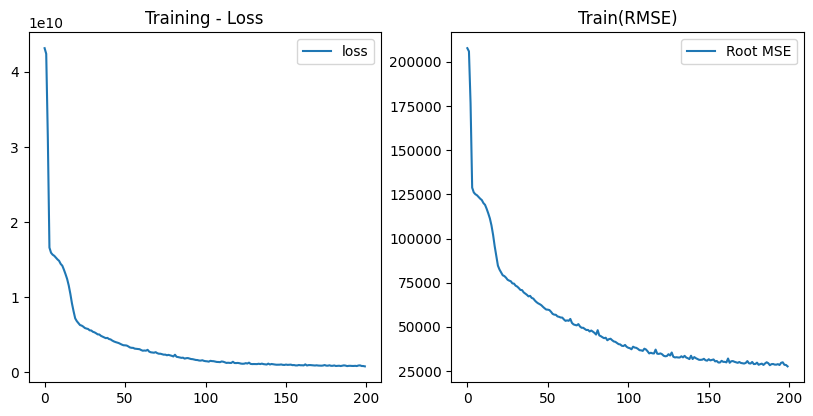

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(fit_history.history['loss'], label='loss')
plt.legend()
plt.title('Training - Loss')
plt.subplot(2,2,2)
plt.plot(fit_history.history['root_mean_squared_error'], label='Root MSE')
plt.legend()
plt.title('Train(RMSE)')

Text(0.5, 1.0, 'Validation(RMSE)')

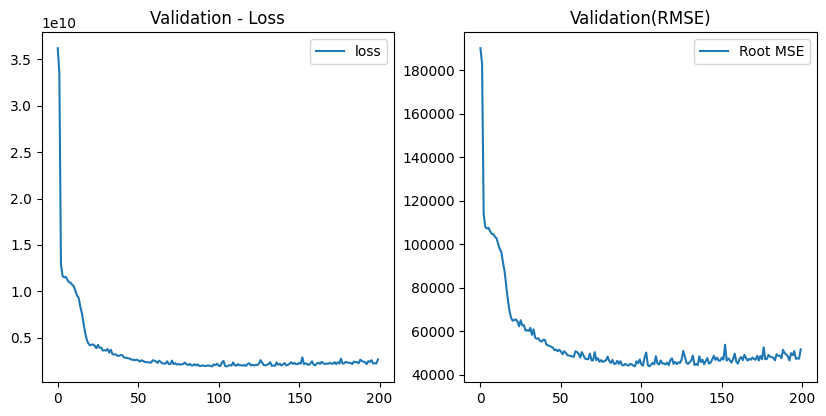

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(fit_history.history['val_loss'], label='loss')
plt.legend()
plt.title('Validation - Loss')
plt.subplot(2,2,2)
plt.plot(fit_history.history['val_root_mean_squared_error'], label='Root MSE')
plt.legend()
plt.title('Validation(RMSE)')